In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

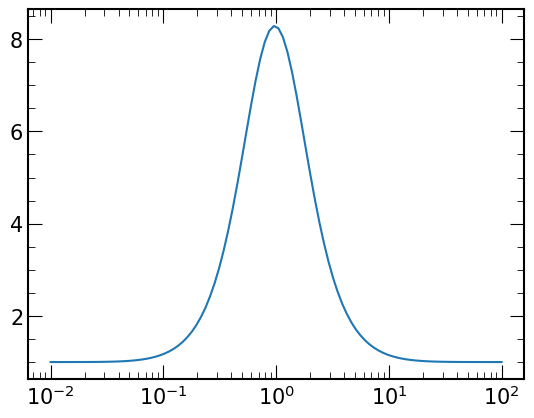

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-b36ebc8b50bb>:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
5.8617048263549805
0.9 0.1


<ipython-input-3-b36ebc8b50bb>:42: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
<ipython-input-3-b36ebc8b50bb>:42: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))


finished until t = 0.0 0.8090629577636719


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 4.794682502746582
finished until t = 1.0 10.54384446144104
finished until t = 1.5 17.0510573387146
finished until t = 2.0 24.625773191452026
finished until t = 2.5 33.43566060066223
finished until t = 3.0 42.5993230342865
finished until t = 3.5 53.28505253791809
finished until t = 4.0 64.11419010162354
finished until t = 4.5 76.29496216773987
finished until t = 5.0 89.31973886489868
finished until t = 5.5 103.15844488143921
finished until t = 6.0 117.60908961296082
finished until t = 6.5 132.81966018676758
finished until t = 7.0 148.84783124923706
finished until t = 7.5 165.87045121192932
finished until t = 8.0 183.76076364517212
finished until t = 8.5 202.45786929130554
finished until t = 9.0 221.71558737754822
finished until t = 9.5 242.2667281627655
finished until t = 10.0 263.4203863143921


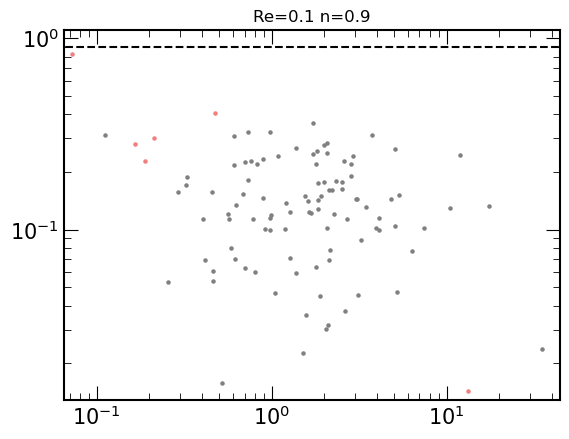

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.584935426712036
0.9 0.3
finished until t = 0.0 0.4948441982269287
finished until t = 0.5 4.344919204711914
finished until t = 1.0 11.737979412078857
finished until t = 1.5 22.93355393409729
finished until t = 2.0 37.14438509941101
finished until t = 2.5 53.938944816589355
finished until t = 3.0 73.25705456733704
finished until t = 3.5 94.92961978912354
finished until t = 4.0 119.07387590408325
finished until t = 4.5 144.33015322685242
finished until t = 5.0 171.87091207504272
finished until t = 5.5 201.0873725414276
finished until t = 6.0 232.83425378799438
finished until t = 6.5 266.0595314502716
finished until t = 7.0 300.42607522010803
finished until t = 7.5 336.4740979671478
finished until t = 8.0 374.0310080051422
finished until t = 8.5 413.07328057289124
finished until t = 9.0 453.1462571620941
finished until t = 9.5 494.8846604824066
finished until t = 10.0 538.0722770690918


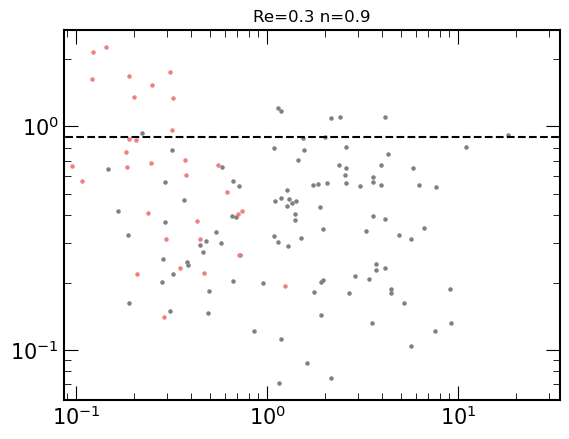

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.930919170379639
0.9 0.5
finished until t = 0.0 0.4550948143005371
finished until t = 0.5 4.215696573257446
finished until t = 1.0 11.840011835098267
finished until t = 1.5 22.811750888824463
finished until t = 2.0 37.68867015838623
finished until t = 2.5 56.08415699005127
finished until t = 3.0 77.87540078163147
finished until t = 3.5 101.7417562007904
finished until t = 4.0 128.74660205841064
finished until t = 4.5 158.1105306148529
finished until t = 5.0 190.26255249977112
finished until t = 5.5 224.831125497818
finished until t = 6.0 261.81004428863525
finished until t = 6.5 302.0710184574127
finished until t = 7.0 343.67988872528076
finished until t = 7.5 388.15356159210205
finished until t = 8.0 434.68835616111755
finished until t = 8.5 483.548465013504
finished until t = 9.0 534.5738682746887
finished until t = 9.5 587.195473909378
finished until t = 10.0 642.5684833526611


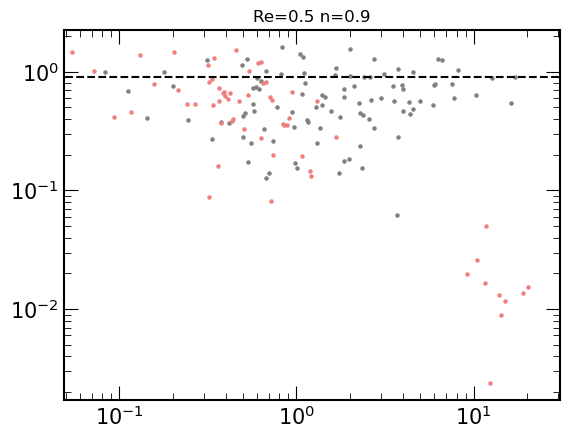

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.44903302192688
0.9 0.7
finished until t = 0.0 0.492079496383667
finished until t = 0.5 4.366087913513184
finished until t = 1.0 11.836233139038086
finished until t = 1.5 22.864524364471436
finished until t = 2.0 37.70216202735901
finished until t = 2.5 56.722092628479004
finished until t = 3.0 79.3537495136261
finished until t = 3.5 107.12572813034058
finished until t = 4.0 138.76198172569275
finished until t = 4.5 174.47673082351685
finished until t = 5.0 214.15614700317383
finished until t = 5.5 258.24041533470154
finished until t = 6.0 312.331583738327
finished until t = 6.5 371.6945972442627
finished until t = 7.0 440.6564562320709
finished until t = 7.5 517.2788782119751
finished until t = 8.0 599.1838088035583
finished until t = 8.5 686.0440864562988
finished until t = 9.0 779.5654089450836
finished until t = 9.5 878.1221928596497
finished until t = 10.0 981.0777666568756


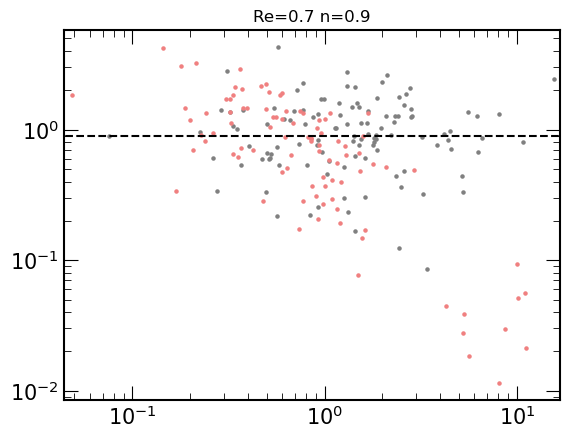

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.12233304977417
0.9 0.9
finished until t = 0.0 0.6715090274810791
finished until t = 0.5 5.538985729217529
finished until t = 1.0 15.054567813873291
finished until t = 1.5 28.77024745941162
finished until t = 2.0 46.97167658805847
finished until t = 2.5 69.67499208450317
finished until t = 3.0 97.40010714530945
finished until t = 3.5 130.24181652069092
finished until t = 4.0 167.46738529205322
finished until t = 4.5 209.37822246551514
finished until t = 5.0 256.2760853767395
finished until t = 5.5 307.6596794128418
finished until t = 6.0 363.86636090278625
finished until t = 6.5 424.05232763290405
finished until t = 7.0 488.26678562164307
finished until t = 7.5 556.9457111358643
finished until t = 8.0 630.2439382076263
finished until t = 8.5 706.3915033340454
finished until t = 9.0 786.764176607132
finished until t = 9.5 870.9422602653503
finished until t = 10.0 959.5797765254974


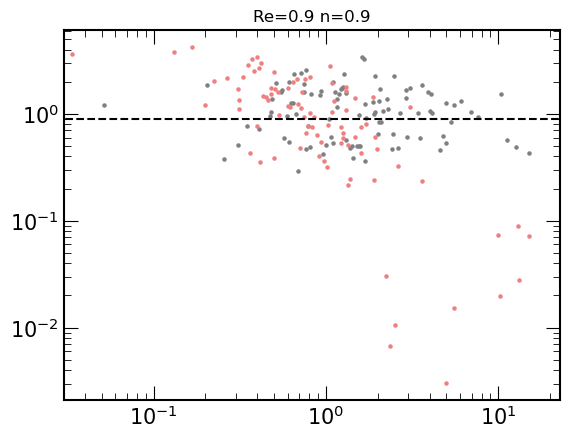

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.352713823318481
0.9 1.1
finished until t = 0.0 0.706031322479248
finished until t = 0.5 6.003492832183838
finished until t = 1.0 15.281575441360474
finished until t = 1.5 29.0029239654541
finished until t = 2.0 46.98435187339783
finished until t = 2.5 69.58069157600403
finished until t = 3.0 96.67313003540039
finished until t = 3.5 128.6010422706604
finished until t = 4.0 165.21123456954956
finished until t = 4.5 207.06708931922913
finished until t = 5.0 253.5463879108429
finished until t = 5.5 304.7938621044159
finished until t = 6.0 360.35854625701904
finished until t = 6.5 420.0813944339752
finished until t = 7.0 483.8701477050781
finished until t = 7.5 552.7470536231995
finished until t = 8.0 627.6593465805054
finished until t = 8.5 704.8956928253174
finished until t = 9.0 786.5611584186554
finished until t = 9.5 873.60191655159
finished until t = 10.0 962.9578545093536


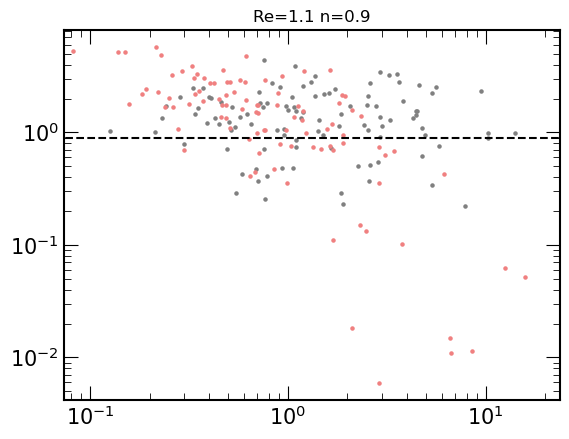

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.018953084945679
0.9 1.3
finished until t = 0.0 0.6986253261566162
finished until t = 0.5 5.710589647293091
finished until t = 1.0 14.253779649734497
finished until t = 1.5 28.01698589324951
finished until t = 2.0 46.18664765357971
finished until t = 2.5 67.7232723236084
finished until t = 3.0 94.04995799064636
finished until t = 3.5 124.35036420822144
finished until t = 4.0 159.47369837760925
finished until t = 4.5 198.5829746723175
finished until t = 5.0 242.1517789363861
finished until t = 5.5 290.281950712204
finished until t = 6.0 342.6206817626953
finished until t = 6.5 399.4467854499817
finished until t = 7.0 460.7487847805023
finished until t = 7.5 525.6553909778595
finished until t = 8.0 594.697568655014
finished until t = 8.5 666.3561244010925
finished until t = 9.0 741.0206730365753
finished until t = 9.5 819.7010579109192
finished until t = 10.0 903.2708463668823


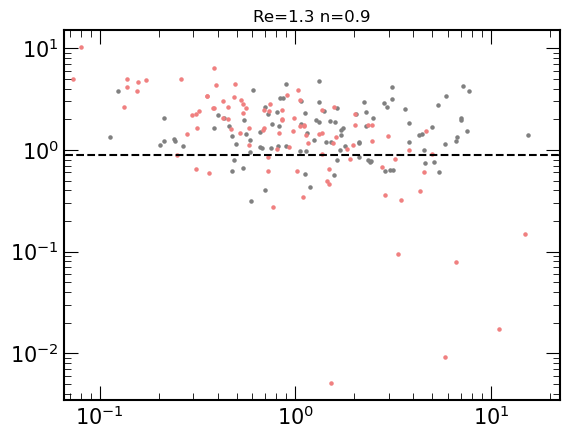

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.744535446166992
0.9 1.5
finished until t = 0.0 0.6784489154815674
finished until t = 0.5 5.278575658798218
finished until t = 1.0 13.873812198638916
finished until t = 1.5 26.461827516555786
finished until t = 2.0 43.020991563797
finished until t = 2.5 63.65271258354187
finished until t = 3.0 88.28918528556824
finished until t = 3.5 117.38022470474243
finished until t = 4.0 149.97720956802368
finished until t = 4.5 187.2642045021057
finished until t = 5.0 228.11346197128296
finished until t = 5.5 273.2155065536499
finished until t = 6.0 323.0702476501465
finished until t = 6.5 376.67372155189514
finished until t = 7.0 434.9131672382355
finished until t = 7.5 497.3598082065582
finished until t = 8.0 565.5911650657654
finished until t = 8.5 636.6973915100098
finished until t = 9.0 710.6548428535461
finished until t = 9.5 792.5697226524353
finished until t = 10.0 878.3017399311066


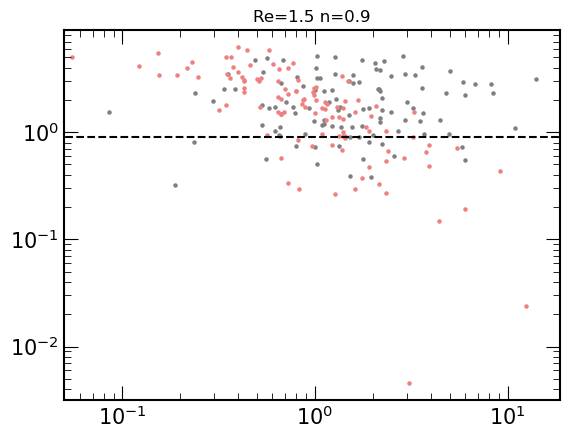

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
12.318770170211792
0.9 1.7
finished until t = 0.0 0.7127501964569092
finished until t = 0.5 5.468585968017578
finished until t = 1.0 13.703118801116943
finished until t = 1.5 25.396644353866577
finished until t = 2.0 41.37166666984558
finished until t = 2.5 60.88028693199158
finished until t = 3.0 83.92309594154358
finished until t = 3.5 110.96764898300171
finished until t = 4.0 141.81087708473206
finished until t = 4.5 177.69905424118042
finished until t = 5.0 216.4985911846161
finished until t = 5.5 260.26744413375854
finished until t = 6.0 306.7050037384033
finished until t = 6.5 357.41054582595825
finished until t = 7.0 412.0785825252533
finished until t = 7.5 470.7674515247345
finished until t = 8.0 533.5764520168304
finished until t = 8.5 600.3985304832458
finished until t = 9.0 671.6310558319092
finished until t = 9.5 747.276707649231
finished until t = 10.0 827.1698222160339


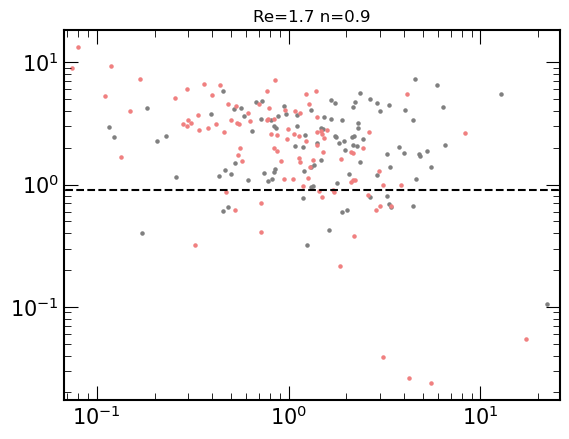

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.241758346557617
0.9 1.9
finished until t = 0.0 0.6301994323730469
finished until t = 0.5 4.634591341018677
finished until t = 1.0 11.963915824890137
finished until t = 1.5 22.81600570678711
finished until t = 2.0 37.037705183029175
finished until t = 2.5 54.75534534454346
finished until t = 3.0 75.7417471408844
finished until t = 3.5 100.2243492603302
finished until t = 4.0 128.03797721862793
finished until t = 4.5 159.36383056640625
finished until t = 5.0 193.9622893333435
finished until t = 5.5 232.01845908164978
finished until t = 6.0 273.6181790828705
finished until t = 6.5 318.9087781906128
finished until t = 7.0 368.0955080986023
finished until t = 7.5 420.1047043800354
finished until t = 8.0 474.56288623809814
finished until t = 8.5 532.5116519927979
finished until t = 9.0 593.7210276126862
finished until t = 9.5 658.2067935466766
finished until t = 10.0 724.7217464447021


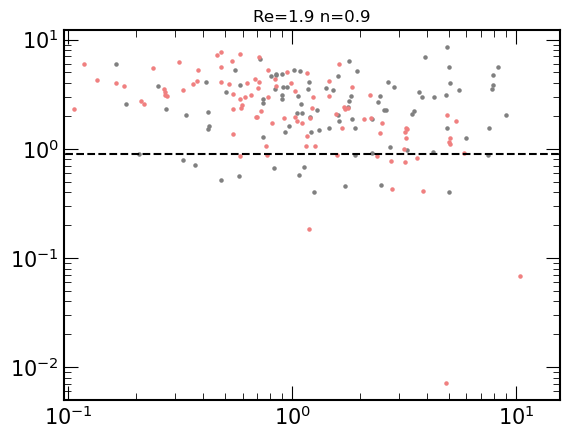

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.327956199645996
0.9 2.1
finished until t = 0.0 0.6716945171356201
finished until t = 0.5 4.8991310596466064
finished until t = 1.0 12.531846523284912
finished until t = 1.5 23.57153081893921
finished until t = 2.0 37.970884561538696
finished until t = 2.5 56.07635259628296
finished until t = 3.0 77.53465151786804
finished until t = 3.5 102.08237099647522
finished until t = 4.0 130.6332869529724
finished until t = 4.5 162.43456959724426
finished until t = 5.0 197.76268410682678
finished until t = 5.5 236.46553897857666
finished until t = 6.0 278.6943905353546
finished until t = 6.5 324.3528616428375
finished until t = 7.0 373.65879917144775
finished until t = 7.5 426.5399549007416
finished until t = 8.0 483.0979218482971
finished until t = 8.5 538.8885157108307
finished until t = 9.0 594.1279940605164
finished until t = 9.5 652.0781075954437
finished until t = 10.0 713.1982204914093


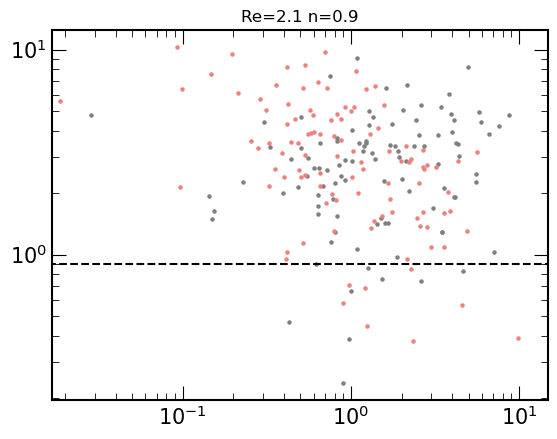

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.014416456222534
0.9 2.3
finished until t = 0.0 0.4874274730682373
finished until t = 0.5 3.36122989654541
finished until t = 1.0 8.614506959915161
finished until t = 1.5 16.250563383102417
finished until t = 2.0 26.409292936325073
finished until t = 2.5 38.95090627670288
finished until t = 3.0 53.90292501449585
finished until t = 3.5 71.3028609752655
finished until t = 4.0 91.22739362716675
finished until t = 4.5 113.64323258399963
finished until t = 5.0 138.65406823158264
finished until t = 5.5 166.79525804519653
finished until t = 6.0 196.76056051254272
finished until t = 6.5 229.42147779464722
finished until t = 7.0 264.70579767227173
finished until t = 7.5 302.65582299232483
finished until t = 8.0 343.30575704574585
finished until t = 8.5 386.26087284088135
finished until t = 9.0 432.0604693889618
finished until t = 9.5 480.84345293045044
finished until t = 10.0 531.8378381729126


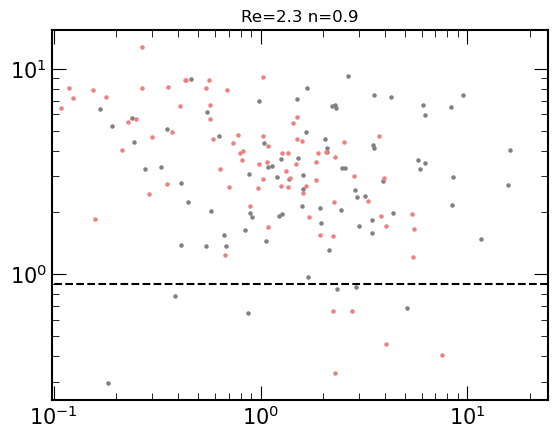

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.219672441482544
0.9 2.5
finished until t = 0.0 0.5678572654724121
finished until t = 0.5 4.028038740158081
finished until t = 1.0 10.42593789100647
finished until t = 1.5 19.609057426452637
finished until t = 2.0 31.55028009414673
finished until t = 2.5 46.32618951797485
finished until t = 3.0 64.11612892150879
finished until t = 3.5 84.78179812431335
finished until t = 4.0 108.21060872077942
finished until t = 4.5 134.6053409576416
finished until t = 5.0 163.87054753303528
finished until t = 5.5 196.12306261062622
finished until t = 6.0 231.19586896896362
finished until t = 6.5 269.12476778030396
finished until t = 7.0 310.10356187820435
finished until t = 7.5 353.96859860420227
finished until t = 8.0 400.6949679851532
finished until t = 8.5 450.80456709861755
finished until t = 9.0 503.4567623138428
finished until t = 9.5 558.7769265174866
finished until t = 10.0 617.2696640491486


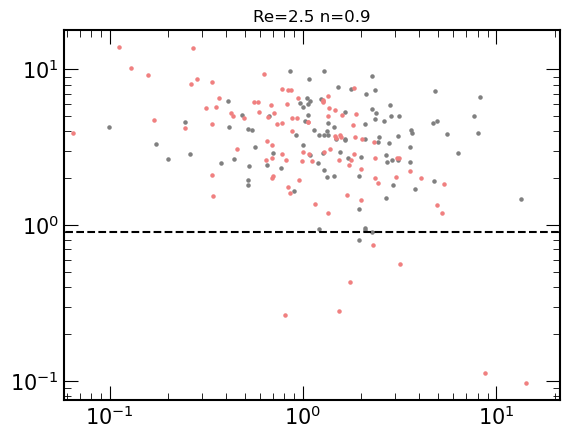

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.217543125152588
0.9 2.7
finished until t = 0.0 0.6133296489715576
finished until t = 0.5 5.00409722328186
finished until t = 1.0 13.179909229278564
finished until t = 1.5 24.98726797103882
finished until t = 2.0 40.76567220687866
finished until t = 2.5 60.655421018600464
finished until t = 3.0 83.89422535896301
finished until t = 3.5 110.71122312545776
finished until t = 4.0 141.17904090881348
finished until t = 4.5 175.34451937675476
finished until t = 5.0 213.4548785686493
finished until t = 5.5 255.46617341041565
finished until t = 6.0 300.3964672088623
finished until t = 6.5 349.19692826271057
finished until t = 7.0 401.8576157093048
finished until t = 7.5 458.46838879585266
finished until t = 8.0 518.6837270259857
finished until t = 8.5 585.4517085552216
finished until t = 9.0 657.8692796230316
finished until t = 9.5 733.6640639305115
finished until t = 10.0 815.1867742538452


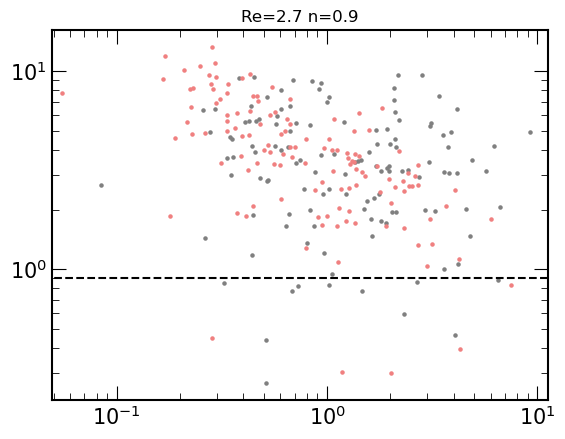

In [3]:
# NFW
#R_e_values = np.arange(0.1, 2.9, 0.2)11
n_values = [0.9]

R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             
        
             